In [ ]:
The needed packages

In [1]:
using Pkg
Pkg.add("BenchmarkTools")
Pkg.add("LinearAlgebra")
Pkg.add("SparseArrays")
Pkg.add("SpeedMapping")
Pkg.add("Random")
Pkg.add("IterativeSolvers")
Pkg.add("KrylovKit")
Pkg.add("Optim")
Pkg.add("ProgressMeter")
Pkg.add("StatsPlots")

# Finding a dominant eigenvalue

In [2]:
using BenchmarkTools, LinearAlgebra, SparseArrays, SpeedMapping, Random

In [3]:
Random.seed!(1234)
n = 100
A = Symmetric(sprand(n, n, 0.1) + 100 * Diagonal(rand(n)))

100×100 Symmetric{Float64, SparseMatrixCSC{Float64, Int64}}:
 69.3495     0.0         0.0       …   0.0        0.0        0.0
  0.0       14.783       0.0           0.0        0.0        0.0
  0.0        0.0        59.4475        0.0        0.0        0.0
  0.0        0.0         0.0           0.0        0.0        0.0
  0.870209   0.0         0.130227      0.0        0.0        0.739634
  0.0        0.0         0.0       …   0.0        0.0        0.0
  0.0        0.0         0.0           0.0        0.0        0.0
  0.0        0.0         0.0           0.0        0.0        0.0
  0.0        0.0         0.0           0.0        0.391718   0.389471
  0.0        0.0493348   0.0           0.747211   0.0        0.0
  0.0        0.0         0.0       …   0.0        0.0        0.0
  0.0        0.0         0.412597      0.0        0.0        0.0
  0.0        0.0         0.0           0.0        0.0        0.0
  ⋮                                ⋱                        
  0.0        0.0       

In [4]:
using IterativeSolvers
val1, _, history = @btime powm!($A, ones(n); verbose = false, maxiter = 100_000, log = true)
println("Value: $val1. ", history)

  5.006 ms (10675 allocations: 951.42 KiB)
Value: 98.79345615494759. Converged after 3176 iterations.


In [5]:
using KrylovKit
val2 = @btime eigsolve($A, 1, :LM)[1][1]

  950.600 μs (475 allocations: 242.70 KiB)


98.79345615494745

In [6]:
function m!(x_out, x_in, A)
    mul!(x_out, A, x_in)
    x_out ./= maximum(abs.(x_out))
end

V, maps = @btime speedmapping(ones(n); m! = (x_out, x_in) -> m!(x_out, x_in, $A))
val3 = (V'A) * V / V'V
println("Value: $val3. Converged after $maps mappings.")

  362.000 μs (972 allocations: 376.61 KiB)
Value: 98.79345615494734. Converged after 139 mappings.


In [7]:
val1 ≈ val2 ≈ val3

true

# Minimizing a high-dimensional Rosenbrock

In [8]:
const N = 500

f(x) = sum(100 * (x[i]^2 - x[i+N])^2 + (x[i] - 1)^2 for i ∈ 1:N) # Rosenbrock objective

function g!(∇, x) # Rosenbrock gradient
    ∇[1:N] .=  400(x[1:N].^2 .- x[N + 1:2N]) .* x[1:N] .+ 2(x[1:N] .- 1)
    ∇[N + 1:2N] .= -200(x[1:N].^2 .- x[N + 1:2N])
    return nothing
end

x₀ = 10 * collect((1:2N) / (2N) .- .5) # A not so judicious starting point

1000-element Vector{Float64}:
 -4.99
 -4.98
 -4.97
 -4.96
 -4.95
 -4.9399999999999995
 -4.93
 -4.92
 -4.91
 -4.9
 -4.89
 -4.88
 -4.87
  ⋮
  4.89
  4.9
  4.91
  4.92
  4.93
  4.9399999999999995
  4.95
  4.96
  4.97
  4.98
  4.99
  5.0

In [9]:
speedmapping(x₀; f, g!)

(minimizer = [0.9999999999999681, 1.0000000000000486, 1.000000000000074, 0.9999999999999997, 0.9999999999999414, 1.0000000000000162, 0.9999999999999953, 1.0000000000000302, 0.9999999999999492, 1.0000000000000326  …  0.9999999999998739, 0.9999999999999739, 1.0000000000001388, 0.9999999999999096, 1.0000000000000457, 0.9999999999999831, 0.9999999999999406, 1.0000000000001, 1.0000000000000577, 0.9999999999999429], maps = 452, f_calls = 11, converged = true, norm_∇ = 2.9480122233040396e-12)

In [10]:
speedmapping(x₀; g!)

(minimizer = [1.0000000000000013, 1.0000000000000557, 1.0000000000001186, 1.0000000000000597, 1.0000000000000289, 0.9999999999999343, 1.000000000000045, 1.0000000000000355, 1.0000000000000782, 1.0000000000000868  …  1.0000000000002522, 1.0000000000002587, 0.9999999999999537, 0.9999999999997179, 1.0000000000002494, 0.9999999999997311, 1.0000000000002107, 0.9999999999998896, 1.0000000000001135, 0.9999999999991994], maps = 526, f_calls = 0, converged = true, norm_∇ = 3.3381122557619837e-12)

In [11]:
speedmapping(x₀; f)

(minimizer = [0.9999999999999335, 1.0000000000000193, 1.0000000000000007, 1.0000000000000278, 1.0000000000000653, 0.9999999999999881, 0.9999999999999697, 0.9999999999999897, 0.9999999999999849, 0.999999999999975  …  1.0000000000002098, 1.0000000000000138, 1.0000000000001492, 0.9999999999999994, 1.0000000000002314, 1.0000000000001192, 1.0000000000000704, 1.000000000000035, 1.0000000000001188, 0.9999999999979968], maps = 588, f_calls = 11, converged = true, norm_∇ = 3.2867554325689855e-12)

In [12]:
upper = [0.5 * ones(N); Inf * ones(N)];
speedmapping(x₀; f, g!, upper)

(minimizer = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5  …  0.25000000000000006, 0.24999999999999997, 0.24999999999999997, 0.25000000000000006, 0.24999999999999997, 0.24999999999999997, 0.25, 0.25000000000000006, 0.25, 0.25], maps = 758, f_calls = 11, converged = true, norm_∇ = 8.311393717638974e-9)

Benchmarking against Optim.jl

In [13]:
using Optim, ProgressMeter, StatsPlots
Optim.Options(g_tol = 1e-8, f_tol = 0, iterations = 1_000_000, x_tol = 0, g_calls_limit = 1_000_000);

function times_distributions(times, title)
    means = round.([mean(1000times[:,i]) for i ∈ 1:3]; digits = 2)
    means_str = "(mean = " .* string.(means) .* " ms)"
    plot(1000times[:,1], seriestype=:stephist, label = "SpeedMapping, ACX " * means_str[1], 
        title = title, xlabel = "milliseconds", ylabel = "frequency", xlims = (0, 1.5 * maximum(means)))
    plot!(1000times[:,2], seriestype=:stephist, label = "Optim, L-BFGS " * means_str[2])
    plot!(1000times[:,3], seriestype=:stephist, label = "Optim, Conjugate Gradient " * means_str[3])
end;

Progress: 100%|█████████████████████████████████████████| Time: 0:02:50


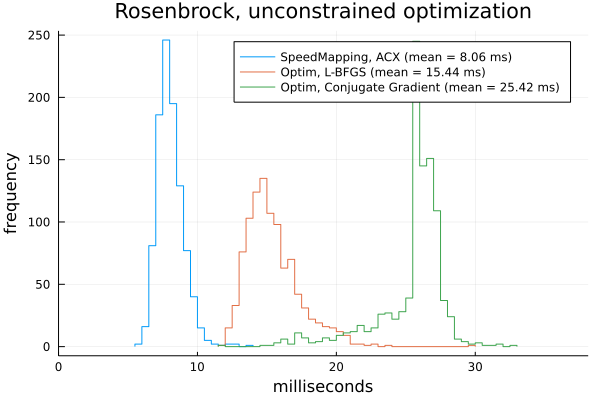

In [99]:
times = zeros(1000,3);
@showprogress for s ∈ 1:1000
    x₀ .= 10 * rand(1000) .- 5
    times[s,1] = minimum([@elapsed(speedmapping(x₀; f, g!, tol = 1e-8)) for i ∈ 1:3])
    times[s,2] = minimum([@elapsed(optimize(f, g!, x₀, LBFGS())) for i ∈ 1:3])
    times[s,3] = minimum([@elapsed(optimize(f, g!, x₀, ConjugateGradient())) for i ∈ 1:3])
end

times_distributions(times, "Rosenbrock, unconstrained optimization")

Progress: 100%|█████████████████████████████████████████| Time: 0:13:40


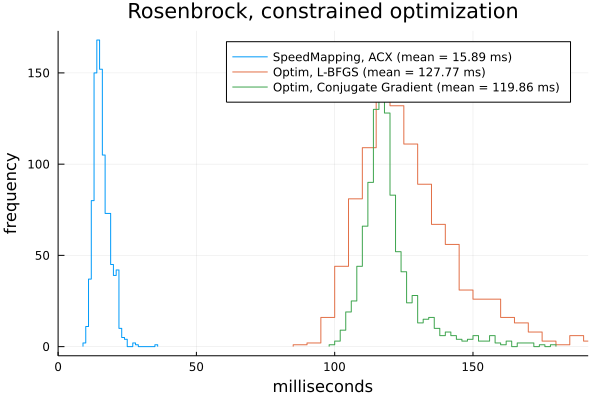

In [101]:
lower = -Inf * ones(1000);

timesc = zeros(1000,3);
@showprogress for s ∈ 1:1000
    x₀ .= [5 * rand(500) .- 5; 10 * rand(500) .- 5]
    timesc[s,1] = minimum([@elapsed(speedmapping(x₀; f, g!, upper, tol = 1e-8)) for i ∈ 1:3])
    timesc[s,2] = minimum([@elapsed(optimize(f, g!, lower, upper, x₀, Fminbox(LBFGS()))) for i ∈ 1:3])
    timesc[s,3] = minimum([@elapsed(optimize(f, g!, lower, upper, x₀, Fminbox(ConjugateGradient()))) for i ∈ 1:3])
end

times_distributions(timesc, "Rosenbrock, constrained optimization")